In [1]:
# Zachary Katz
# zachary_katz@mines.edu
# 27 May 2025

"""
Example harmonic analysis 
"""

# Extensions
%load_ext autoreload
%autoreload 2

# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from utide import solve
import pandas as pd

import earthaccess
from pathlib import Path
import h5py
from astropy.time import Time
import Tides.Tides as Tides
import datetime
import seaborn as sns

/home/zkatz/Research/harmonic-analysis/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Satellite repeat times [hr]
HR_IN_DAY = 24
SEC_IN_HR = 3600
T_icesat2 = 90.8193 * HR_IN_DAY  # 90.8193 days in hrs (From ATL03 POD ATBD)
T_swot = 20.86455 * HR_IN_DAY  # 21 days in hrs
T_cryosat_subcycle = 28.941 * HR_IN_DAY  # 28 days in hrs
T_jason = 9.9156 * HR_IN_DAY  # 9 days in hrs

# Tidal constituents [hr]
M2 = 12.4206012
S2 = 12
N2 = 12.65834751
K2 = 11.96723606

K1 = 23.9344721
O1 = 25.81933871
P1 = 24.06588766
Q1 = 26.868350

constituents = {
    "M2": M2,
    "S2": S2,
    "N2": N2,
    "K2": K2,
    "K1": K1,
    "O1": O1,
    "P1": P1,
    "Q1": Q1,
}

In [3]:
def tide_model(t, periods, parameters):
    """
    Generate the tide from synthetic data.

    Parameters
    ----------
    t : List
        List of sampling times in hours
    periods : dict
        Dictionary of tidal constituent periods in hours
    parameters : list
        List in form [A1, A2, ... , phi_1, phi_2, ...]
        where A is the amplitude in m and phi is the phase shift in radians

    Returns
    -------
    modeled : list
        Tides at time t as estimated by the model
    """
    assert len(parameters) == 2 * len(
        periods
    ), "Parameters must be twice the number of periods"

    model = np.zeros_like(t, dtype=float)
    n = len(periods)
    for i in range(n):
        A = parameters[i]
        phi = parameters[i + n]
        model += A * np.cos(2 * np.pi * t / periods[i] - phi)
    return model


def residuals(parameters, t, data, periods):
    """
    Residual function for scipy's least_squares
    Scipy does the squaring for us.
    """
    return tide_model(t, periods, parameters) - data

True: 1.000, Fitted: 0.990
True: 2.000, Fitted: 2.007
True: 0.300, Fitted: 0.328
True: 2.000, Fitted: 1.967
True: 1.000, Fitted: 1.006
True: 2.000, Fitted: 1.966
True: 0.000, Fitted: -0.014
True: 1.000, Fitted: 1.022
True: 0.000, Fitted: 0.006
True: 0.000, Fitted: 0.009
True: 0.000, Fitted: -0.032
True: 0.000, Fitted: -0.005
True: 1.571, Fitted: -4.704
True: 0.393, Fitted: 0.392
True: 0.000, Fitted: 0.558
True: 0.785, Fitted: 0.792


Text(0, 0.5, 'Tide [m]')

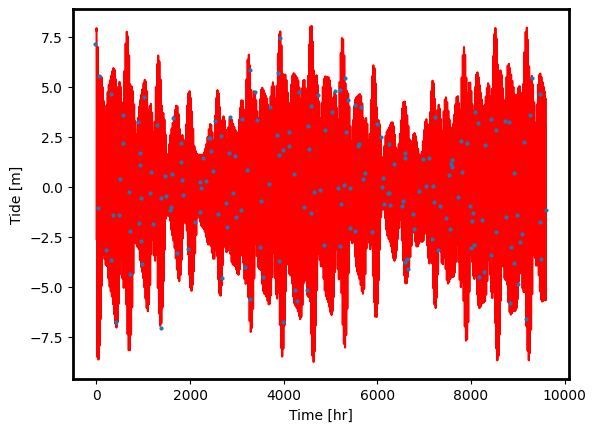

In [4]:
step = T_swot // 10  # hrs
t = np.arange(0, 400 * 24, step)
t = t + np.random.normal(0, 100, len(t))  # Nonuniform sampling
periods = [constituents[c] for c in constituents]
true_values = [1, 2, 0.3, 2, 1, 2, 0, 1, 0, 0, 0, 0, np.pi / 2, np.pi / 8, 0, np.pi / 4]

synthetic_data = tide_model(t, periods, true_values) + np.random.normal(0, 0.2, len(t))

initial_guess = [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
fit = least_squares(residuals, initial_guess, args=(t, synthetic_data, periods))

# Print real and fitted parameters
for true, fitted in zip(true_values, fit.x):
    print(f"True: {true:.3f}, Fitted: {fitted:.3f}")

fig, ax = plt.subplots()
ax.scatter(t, synthetic_data, s=4)
fit_times = np.arange(0, 400 * 24, 0.1)
fit_tide = tide_model(fit_times, periods, fit.x)
ax.plot(fit_times, fit_tide, color="red", zorder=0)
ax.set_xlabel("Time [hr]")
ax.set_ylabel("Tide [m]")

In [5]:
t_as_time = pd.date_range(start="2020-01-02T08:50:00", periods=len(t), freq=f"{step}h")
# Utide analysis
soln = solve(t_as_time, synthetic_data, lat=-84.2986, method="ols", conf_int="linear")
for i, constitutent in enumerate(soln.name):
    print(
        f"Constitutent: {constitutent}, Amplitude: {soln.A[i]}, A_ci: {soln.A_ci[i]} Phase: {soln.g[i]*np.pi/180}, g_ci: {soln.g_ci[i]}"
    )

solve: matrix prep ... solution ... done.
Constitutent: BET1, Amplitude: 60498171037.10802, A_ci: nan Phase: 5.03349015059535, g_ci: nan
Constitutent: 2MN6, Amplitude: 28057918113.636524, A_ci: nan Phase: 1.112463908622129, g_ci: nan
Constitutent: SA, Amplitude: 5475362529.093723, A_ci: 3.7513857350032255e-05 Phase: 2.068064832954556, g_ci: 2.488269981052871e-13
Constitutent: SSA, Amplitude: 1942252587.8051362, A_ci: nan Phase: 0.08302950119604174, g_ci: nan
Constitutent: MKS2, Amplitude: 1425852295.2864108, A_ci: nan Phase: 5.846591704837484, g_ci: nan
Constitutent: MO3, Amplitude: 1137593721.7251496, A_ci: nan Phase: 2.7455828648406615, g_ci: nan
Constitutent: NO1, Amplitude: 968444424.6829505, A_ci: nan Phase: 6.117359602865134, g_ci: nan
Constitutent: CHI1, Amplitude: 967165816.3877195, A_ci: nan Phase: 4.352175812181776, g_ci: nan
Constitutent: M3, Amplitude: 743053133.9349165, A_ci: nan Phase: 4.119641265601683, g_ci: nan
Constitutent: M2, Amplitude: 698568797.913095, A_ci: nan P

In [6]:
# Try with IceSat-2 crossover at gz05
# User-defined path
data_path = "../data/ATL11/"

# Download ATL11 if necessary
results = earthaccess.search_data(
    short_name="ATL11",
    granule_name="ATL11_134011_0326_006_12.h5",
)
print(results)
earthaccess.download(results, data_path, provider="POCLOUD")
files = list(Path(data_path).glob("*.h5"))

[Collection: {'EntryTitle': 'ATLAS/ICESat-2 L3B Slope-Corrected Land Ice Height Time Series V006'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -153.59526, 'Latitude': -78.98162}, {'Longitude': -153.87878, 'Latitude': -78.9677}, {'Longitude': -153.99141, 'Latitude': -78.98917}, {'Longitude': -155.48991, 'Latitude': -80.24384}, {'Longitude': -160.10742, 'Latitude': -82.8004}, {'Longitude': -164.22914, 'Latitude': -84.16105}, {'Longitude': 178.20076, 'Latitude': -86.664}, {'Longitude': 157.00415, 'Latitude': -87.60905}, {'Longitude': 88.84637, 'Latitude': -87.43669}, {'Longitude': 56.05837, 'Latitude': -84.17317}, {'Longitude': 49.46781, 'Latitude': -81.64929}, {'Longitude': 47.27274, 'Latitude': -80.24236}, {'Longitude': 45.77733, 'Latitude': -78.98982}, {'Longitude': 45.71627, 'Latitude': -78.97243}, {'Longitude': 45.60891, 'Latitude': -78.96835}, {'Longitude': 45.53695, 'Latitude': -78.97633}, {'Longitude': 45.24915, 

QUEUEING TASKS | : 100%|██████████| 2/2 [00:00<00:00, 1483.66it/s]
PROCESSING TASKS | : 100%|██████████| 2/2 [00:00<00:00, 6973.07it/s]
COLLECTING RESULTS | : 100%|██████████| 2/2 [00:00<00:00, 16008.79it/s]


In [7]:
# Make array of ATL11 data
data_arr = []

# Each reference track pair is a group
group = ["/pt1/", "/pt2/", "/pt3/"]

# Loop over files
for file in files[:7]:
    # Loop over pairs
    for i, g in enumerate(group):
        data = {}
        # Load variables into dictionary list
        with h5py.File(file, "r") as fi:
            data["t_ref"] = fi["/ancillary_data/atlas_sdp_gps_epoch"][
                :
            ]  # ICESat-2 reference epoch
            data["filename"] = file
            data["group"] = g

            # Crossing track data
            data["x_q_flag"] = fi[g + "crossing_track_data/atl06_quality_summary"][
                :
            ]  # 0 likely no problem; 1 problems #See table 4-4 in IceSat2 ATL11 ATBD
            data["x_lat"] = fi[g + "crossing_track_data/latitude"][
                :
            ]  # Latitude [degrees]
            data["x_lon"] = fi[g + "crossing_track_data/longitude"][
                :
            ]  # Longitude [degrees]
            data["x_h_corr"] = fi[g + "crossing_track_data/h_corr"][
                :
            ]  # Mean corrected height [m]
            data["x_t_dt"] = fi[g + "crossing_track_data/delta_time"][
                :
            ]  # GPS seconds since reference epoch
            data["x_cycle_number"] = fi[g + "crossing_track_data/cycle_number"][
                :
            ]  # Cycle
            data["x_rgt"] = fi[g + "crossing_track_data/rgt"][
                :
            ]  # Reference ground track
            data["x_spot_crossing"] = fi[g + "crossing_track_data/spot_crossing"][
                :
            ]  # Spot  number
            data["x_ref_pt"] = fi[g + "crossing_track_data/ref_pt"][
                :
            ]  # Reference point

            time_temp = data["t_ref"] + data["x_t_dt"]
            data["x_time"] = Time(
                time_temp, format="gps"
            ).iso  # Convert to readable time

            # Main track data
            data["lat"] = fi[g + "/latitude"][:]  # Latitude [degrees]
            data["lon"] = fi[g + "/longitude"][:]  # Longitude [degrees]
            data["h_corr"] = fi[g + "/h_corr"][:]  # Mean corrected height [m]
            data["t_dt"] = fi[g + "/delta_time"][:]  # GPS seconds since reference epoch
            data["q_flag"] = fi[g + "/quality_summary"][
                :
            ]  # 0 likely no problem; 1 problems #See table 4-4 in IceSat2 ATL11 ATBD
            data["cycle_number"] = fi[g + "/cycle_number"][:]  # Cycle
            data["ref_pt"] = fi[g + "/ref_pt"][:]  # Reference point
            time_temp = data["t_ref"] + data["t_dt"]
            data["time"] = Time(time_temp, format="gps").iso  # Convert to readable time

        data_arr.append(data)

/home/zkatz/Research/harmonic-analysis/.venv/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/home/zkatz/Research/harmonic-analysis/.venv/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.


In [8]:
# Find closest point to gz05 for data_arr[0]
trk_X = data_arr[0]
gz05_lat, gz05_lon = -84.2986, -164.5206
lat_lon = np.column_stack((trk_X["x_lat"], trk_X["x_lon"]))
dists = np.linalg.norm(lat_lon - [gz05_lat, gz05_lon], axis=1)
min_index = np.argmin(dists)
print(lat_lon[min_index], dists[min_index], min_index)
ref_pt = trk_X["x_ref_pt"][min_index]

mskx = (trk_X["x_ref_pt"] == ref_pt) & (trk_X["x_t_dt"] < 2e300)
msk = trk_X["ref_pt"] == ref_pt
print(trk_X["x_rgt"][mskx])
mskd_lat = trk_X["lat"][msk]
mskd_lon = trk_X["lon"][msk]
mskd_xlat = trk_X["x_lat"][mskx]
mskd_xlon = trk_X["x_lon"][mskx]
mskd_xh = trk_X["x_h_corr"][mskx]
mskd_h = trk_X["h_corr"][msk]
msk_h = mskd_h < 1e30
mskd_h = mskd_h[msk_h]
mskd_xt = trk_X["x_time"][mskx]
mskd_xcycle = trk_X["x_cycle_number"][mskx]
mskd_xrgt = trk_X["x_rgt"][mskx]

mskd_t = trk_X["time"][msk]
mskd_tdt = trk_X["t_dt"][msk]
msk_t = mskd_tdt < 1e300
mskd_t = mskd_t[msk_t]
msk_t = msk_t.flatten()
mskd_cycle = trk_X["cycle_number"][msk_t]

mskd_lon = np.ones(len(mskd_t)) * mskd_lon
mskd_lat = np.ones(len(mskd_t)) * mskd_lat
mskd_rgt = np.ones(len(mskd_t), dtype=int) * int(files[0].stem.split("_")[1][:4])

print(mskd_h, mskd_xh)
print(
    len(mskd_lat),
    len(mskd_lon),
    len(mskd_t),
    len(mskd_cycle),
    len(mskd_rgt),
    len(mskd_h),
)
print(
    len(mskd_xlat),
    len(mskd_xlon),
    len(mskd_xt),
    len(mskd_xcycle),
    len(mskd_xrgt),
    len(mskd_xh),
)
df1 = pd.DataFrame(
    {
        "lat": mskd_xlat,
        "lon": mskd_xlon,
        "time": mskd_xt,
        "cycle_number": mskd_xcycle,
        "rgt": mskd_xrgt,
        "h_corr": mskd_xh,
    }
)
df2 = pd.DataFrame(
    {
        "lat": mskd_lat,
        "lon": mskd_lon,
        "time": mskd_t,
        "cycle_number": mskd_cycle,
        "rgt": mskd_rgt,
        "h_corr": mskd_h,
    }
)
df = pd.concat([df1, df2], ignore_index=True)
df = df.sort_values(by=["time"]).reset_index(drop=True)

df = [df[(df["h_corr"] < 80) & (df["h_corr"] > 30)]]
df = df[0]

# Remove mean from h_corr

df["h_corr_demeaned"] = df["h_corr"] - df["h_corr"].mean()

# Convert time to hours since first time
df["datetime"] = df["time"]
df["time"] = (
    pd.to_datetime(df["time"]) - pd.to_datetime(df["time"].iloc[0])
).dt.total_seconds() / SEC_IN_HR
df

[ -84.46755426 -164.46442599] 0.17804791712252604 46681
[191 191 191 191 191 191 191 191 191 191 191 191 191 191 191]
[57.62206  57.62126  57.70342  57.570408 57.457043 57.575745 57.610012
 57.386513 57.393543 57.44477  57.475384 57.565865 57.46413  57.43338
 57.476406] [  57.568565   57.554234   57.591793  -13.927306   57.51495    57.607418
   57.659885   57.446274   57.559795   57.48808    57.404545   57.56506
 -105.447296   57.562134   57.772705]
15 15 15 15 15 15
15 15 15 15 15 15


,lat,lon,time,cycle_number,rgt,h_corr,h_corr_demeaned,datetime
0,-84.467554,-164.464426,0.000000,5,1340,57.622059,0.082939,2019-12-23 16:23:03.852
1,-84.467554,-164.464426,374.060439,6,191,57.568565,0.029446,2020-01-08 06:26:41.432
2,-84.467554,-164.464426,2179.662211,6,1340,57.621262,0.082142,2020-03-23 12:02:47.811
3,-84.467554,-164.464426,2553.723441,7,191,57.554234,0.015114,2020-04-08 02:06:28.239
4,-84.467554,-164.464426,4733.386034,8,191,57.591793,0.052673,2020-07-07 21:46:13.576
5,-84.467554,-164.464426,6538.989086,8,1340,57.703419,0.164299,2020-09-21 03:22:24.562
7,-84.467554,-164.464426,8718.653405,9,1340,57.570408,0.031288,2020-12-20 23:02:16.109
8,-84.467554,-164.464426,10898.317491,10,1340,57.457043,-0.082077,2021-03-21 18:42:06.818
9,-84.467554,-164.464426,11272.379188,11,191,57.514950,-0.024170,2021-04-06 08:45:48.929
10,-84.467554,-164.464426,13077.981669,11,1340,57.575745,0.036625,2021-06-20 14:21:57.860


In [9]:
demeaned_for_comp = df["h_corr_demeaned"].values

True: 0.125, Fitted: 0.00925
True: 0.138, Fitted: 0.05225
True: 0.112, Fitted: 0.01217
True: 0.048, Fitted: 0.02826
True: 0.452, Fitted: 0.04089
True: 0.371, Fitted: 0.07440
True: 0.144, Fitted: 0.09120
True: 0.076, Fitted: 0.03018
True: 221.062, Fitted: 0.73888
True: 164.575, Fitted: 1.15640
True: 132.822, Fitted: 0.67447
True: 174.373, Fitted: 1.00921
True: 198.697, Fitted: 0.31745
True: 182.270, Fitted: 0.30275
True: 195.884, Fitted: 0.65777
True: 172.692, Fitted: 0.76311


Text(0, 0.5, 'Tide [m]')

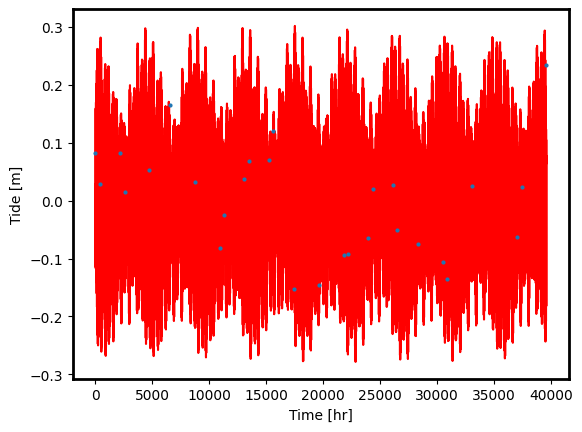

In [10]:
t = df["time"].values
data = df["h_corr_demeaned"].values
periods = [constituents[c] for c in constituents]

# From gz05 harmonic analysis
true_values = [
    0.125,
    0.138,
    0.112,
    0.048,
    0.452,
    0.371,
    0.144,
    0.076,
    221.062,
    164.575,
    132.822,
    174.373,
    198.697,
    182.270,
    195.884,
    172.692,
]
initial_guess = [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
fit = least_squares(residuals, initial_guess, args=(t, data, periods))

IS2_MYHA = []
# Print real and fitted parameters
for true, fitted in zip(true_values, fit.x):
    fitted = np.abs(fitted)
    print(f"True: {true:.3f}, Fitted: {fitted:.5f}")
    IS2_MYHA.append(fitted)

fig, ax = plt.subplots()
ax.scatter(t, data, s=4)
fit_times = np.arange(0, df["time"].iloc[-1], 0.1)
fit_tide = tide_model(fit_times, periods, fit.x)
ax.plot(fit_times, fit_tide, color="red", zorder=0)
ax.set_xlabel("Time [hr]")
ax.set_ylabel("Tide [m]")

In [11]:
# Utide analysis
t = df["time"].values
data = df["h_corr"].values
soln_IS2_UTIDE = solve(t, data, lat=-84.2986, method="ols", conf_int="MC")
for i, constitutent in enumerate(soln.name):
    print(
        f"Constitutent: {constitutent}, Amplitude: {soln.A[i]}, A_ci: {soln.A_ci[i]} Phase: {soln.g[i]*np.pi/180}, g_ci: {soln.g_ci[i]}"
    )

solve: matrix prep ... solution ... done.
Constitutent: BET1, Amplitude: 60498171037.10802, A_ci: nan Phase: 5.03349015059535, g_ci: nan
Constitutent: 2MN6, Amplitude: 28057918113.636524, A_ci: nan Phase: 1.112463908622129, g_ci: nan
Constitutent: SA, Amplitude: 5475362529.093723, A_ci: 3.7513857350032255e-05 Phase: 2.068064832954556, g_ci: 2.488269981052871e-13
Constitutent: SSA, Amplitude: 1942252587.8051362, A_ci: nan Phase: 0.08302950119604174, g_ci: nan
Constitutent: MKS2, Amplitude: 1425852295.2864108, A_ci: nan Phase: 5.846591704837484, g_ci: nan
Constitutent: MO3, Amplitude: 1137593721.7251496, A_ci: nan Phase: 2.7455828648406615, g_ci: nan
Constitutent: NO1, Amplitude: 968444424.6829505, A_ci: nan Phase: 6.117359602865134, g_ci: nan
Constitutent: CHI1, Amplitude: 967165816.3877195, A_ci: nan Phase: 4.352175812181776, g_ci: nan
Constitutent: M3, Amplitude: 743053133.9349165, A_ci: nan Phase: 4.119641265601683, g_ci: nan
Constitutent: M2, Amplitude: 698568797.913095, A_ci: nan P

In [23]:
# Try with taking points from CATS
tide_dir = "/mnt/c/users/ZacharyKatz/Desktop/Research/Background"
tide_mod = "CATS2008-v2023"

tide_times = df["datetime"].values
tide_times = [datetime.datetime.strptime(t, "%Y-%m-%d %H:%M:%S.%f") for t in tide_times]
gz05_lat = -84.2986
gz05_lon = -164.5206

tides = Tides.Tide(tide_mod, tide_dir)
tide_results = tides.tidal_elevation(
    [gz05_lon],
    [gz05_lat],
    tide_times,
).data.T[0]

['m2', 's2', 'n2', 'k2', 'k1', 'o1', 'p1', 'q1', 'mf', 'mm']


True: 0.125, Fitted: 0.09730
True: 0.138, Fitted: 0.17967
True: 0.112, Fitted: 0.14353
True: 0.048, Fitted: 0.09748
True: 0.452, Fitted: 0.48571
True: 0.371, Fitted: 0.39125
True: 0.144, Fitted: 0.14619
True: 0.076, Fitted: 0.11820
True: 221.062, Fitted: 0.17362
True: 164.575, Fitted: 0.85848
True: 132.822, Fitted: 0.20203
True: 174.373, Fitted: 0.79873
True: 198.697, Fitted: 0.72120
True: 182.270, Fitted: 0.61805
True: 195.884, Fitted: 0.56281
True: 172.692, Fitted: 1.09587


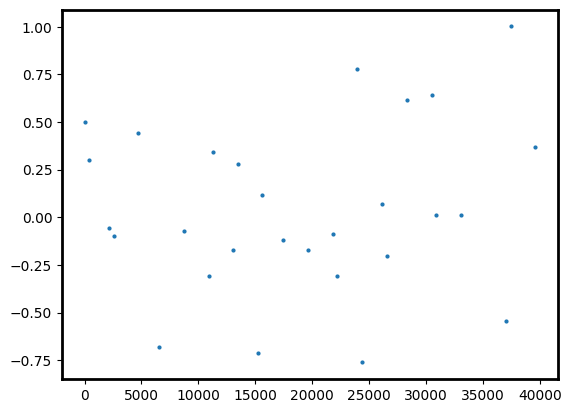

In [13]:
periods = [constituents[c] for c in constituents]
t = df["time"].values
data = tide_results / 100
# From gz05 harmonic analysis
true_values = [
    0.125,
    0.138,
    0.112,
    0.048,
    0.452,
    0.371,
    0.144,
    0.076,
    221.062,
    164.575,
    132.822,
    174.373,
    198.697,
    182.270,
    195.884,
    172.692,
]
initial_guess = [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
fit = least_squares(residuals, initial_guess, args=(t, data, periods))

CATS_AT_IS2 = []
# Print real and fitted parameters
for true, fitted in zip(true_values, fit.x):
    fitted = np.abs(fitted)
    print(f"True: {true:.3f}, Fitted: {fitted:.5f}")
    CATS_AT_IS2.append(fitted)

fig, ax = plt.subplots()
ax.scatter(t, data, s=4)

[ 0.49964329  0.30171924 -0.05844579 -0.10021849  0.44223632 -0.67834144
 -0.07358185 -0.3086577   0.3413521  -0.17370643  0.27715071 -0.71000978
  0.11545493 -0.11680426 -0.17223546 -0.08656803 -0.30621945  0.77688623
 -0.76187173  0.06768874 -0.2036106   0.61690315  0.64244139  0.01139024
  0.00982129 -0.54342239  1.00119367  0.36867744]
[ 0.08293915  0.02944565  0.08214188  0.01511383  0.05267334  0.16429901
  0.03128815 -0.08207703 -0.02416992  0.03662491  0.06829834  0.07089233
  0.12076569 -0.15260696 -0.14557648 -0.09434891 -0.09284592 -0.06373596
  0.02067566  0.02674484 -0.05104065 -0.07498932 -0.10573959 -0.13457489
  0.02593994 -0.06271362  0.02301407  0.23358536]


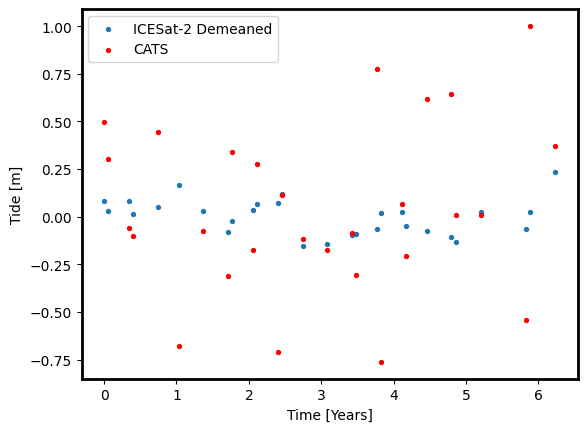

In [24]:
print(tide_results / 100)
print(demeaned_for_comp)
fig, ax = plt.subplots()
ax.scatter(t / 24 / 265, demeaned_for_comp, s=8, label="ICESat-2 Demeaned")
ax.scatter(t / 24 / 265, tide_results / 100, s=8, color="red", label="CATS")
ax.set_xlabel("Time [Years]")
ax.set_ylabel("Tide [m]")
ax.legend()

In [15]:
# See if we can get the correct answer by sampling more often.

# Hourly sampling between the first and last time
tide_times = pd.date_range(
    start=df["datetime"].iloc[0], end=df["datetime"].iloc[-1], freq="h"
)

gz05_lat = -84.2986
gz05_lon = -164.5206

tides = Tides.Tide(tide_mod, tide_dir)
tide_results = tides.tidal_elevation(
    [gz05_lon],
    [gz05_lat],
    tide_times,
).data.T[0]

['m2', 's2', 'n2', 'k2', 'k1', 'o1', 'p1', 'q1', 'mf', 'mm']


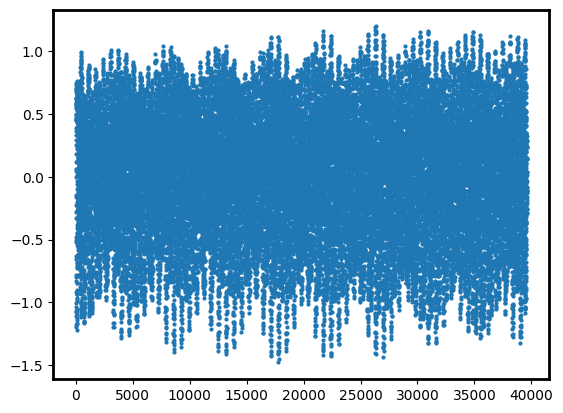

In [ ]:
# Convert tide_times to hours since first time
plot_times = (tide_times - tide_times[0]).total_seconds() / SEC_IN_HR

# Plot
fig, ax = plt.subplots()
ax.scatter(plot_times, tide_results / 100, s=4)

In [17]:
# Utide analysis
soln_CATS_UTIDE = solve(
    tide_times, tide_results / 100, lat=-84.2986, method="ols", conf_int="MC"
)
for i, constitutent in enumerate(soln.name):
    print(
        f"Constitutent: {constitutent}, Amplitude: {soln.A[i]}, A_ci: {soln.A_ci[i]} Phase: {soln.g[i]*np.pi/180}, g_ci: {soln.g_ci[i]}"
    )

solve: matrix prep ... solution ... done.
Constitutent: BET1, Amplitude: 60498171037.10802, A_ci: nan Phase: 5.03349015059535, g_ci: nan
Constitutent: 2MN6, Amplitude: 28057918113.636524, A_ci: nan Phase: 1.112463908622129, g_ci: nan
Constitutent: SA, Amplitude: 5475362529.093723, A_ci: 3.7513857350032255e-05 Phase: 2.068064832954556, g_ci: 2.488269981052871e-13
Constitutent: SSA, Amplitude: 1942252587.8051362, A_ci: nan Phase: 0.08302950119604174, g_ci: nan
Constitutent: MKS2, Amplitude: 1425852295.2864108, A_ci: nan Phase: 5.846591704837484, g_ci: nan
Constitutent: MO3, Amplitude: 1137593721.7251496, A_ci: nan Phase: 2.7455828648406615, g_ci: nan
Constitutent: NO1, Amplitude: 968444424.6829505, A_ci: nan Phase: 6.117359602865134, g_ci: nan
Constitutent: CHI1, Amplitude: 967165816.3877195, A_ci: nan Phase: 4.352175812181776, g_ci: nan
Constitutent: M3, Amplitude: 743053133.9349165, A_ci: nan Phase: 4.119641265601683, g_ci: nan
Constitutent: M2, Amplitude: 698568797.913095, A_ci: nan P

In [18]:
tide_times

DatetimeIndex(['2019-12-23 16:23:03.852000', '2019-12-23 17:23:03.852000',
               '2019-12-23 18:23:03.852000', '2019-12-23 19:23:03.852000',
               '2019-12-23 20:23:03.852000', '2019-12-23 21:23:03.852000',
               '2019-12-23 22:23:03.852000', '2019-12-23 23:23:03.852000',
               '2019-12-24 00:23:03.852000', '2019-12-24 01:23:03.852000',
               ...
               '2024-06-29 14:23:03.852000', '2024-06-29 15:23:03.852000',
               '2024-06-29 16:23:03.852000', '2024-06-29 17:23:03.852000',
               '2024-06-29 18:23:03.852000', '2024-06-29 19:23:03.852000',
               '2024-06-29 20:23:03.852000', '2024-06-29 21:23:03.852000',
               '2024-06-29 22:23:03.852000', '2024-06-29 23:23:03.852000'],
              dtype='datetime64[ns]', length=39608, freq='h')

In [19]:
periods = [constituents[c] for c in constituents]
data = tide_results / 100
# From gz05 harmonic analysis
true_values = [
    0.125,
    0.138,
    0.112,
    0.048,
    0.452,
    0.371,
    0.144,
    0.076,
    221.062,
    164.575,
    132.822,
    174.373,
    198.697,
    182.270,
    195.884,
    172.692,
]
initial_guess = [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
fit = least_squares(residuals, initial_guess, args=(plot_times, data, periods))


# Print real and fitted parameters
for true, fitted in zip(true_values, fit.x):
    fitted = np.abs(fitted)
    print(f"True: {true:.3f}, Fitted: {fitted:.5f}")

True: 0.125, Fitted: 0.12296
True: 0.138, Fitted: 0.14448
True: 0.112, Fitted: 0.13703
True: 0.048, Fitted: 0.07297
True: 0.452, Fitted: 0.47718
True: 0.371, Fitted: 0.39820
True: 0.144, Fitted: 0.15861
True: 0.076, Fitted: 0.08660
True: 221.062, Fitted: 0.31451
True: 164.575, Fitted: 0.50177
True: 132.822, Fitted: 0.29721
True: 174.373, Fitted: 0.91438
True: 198.697, Fitted: 0.74095
True: 182.270, Fitted: 0.71313
True: 195.884, Fitted: 0.82368
True: 172.692, Fitted: 10.99080


In [20]:
# load gz05 data and perform 2 harmonic analyses in UTIDE on SERAC:

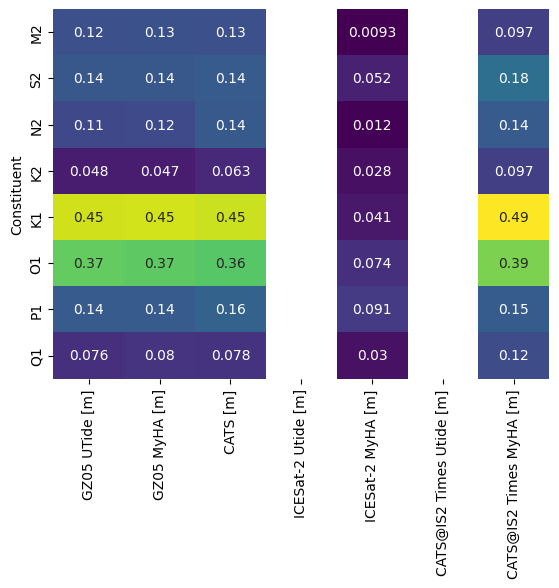

In [28]:
# Summary Plot

# Table of constitutents colored by True - Estimated from my simple HA and python's UTide

df_plotting = pd.DataFrame(
    {
        "Constituent": list(constituents.keys()),
        "GZ05 UTide [m]": true_values[:8],
        "GZ05 MyHA [m]": [
            0.12663,
            0.13840,
            0.11655,
            0.04692,
            0.45270,
            0.36785,
            0.14390,
            0.08005,
        ],  # From UTide on SERAC
        "CATS [m]": [
            0.12530586123466492,
            0.14462734758853912,
            0.13967309892177582,
            0.06251237541437149,
            0.44746169447898865,
            0.35937005281448364,
            0.15769679844379425,
            0.07832222431898117,
        ],
        "ICESat-2 Utide [m]": [np.nan] * 8,
        "ICESat-2 MyHA [m]": IS2_MYHA[:8],
        "CATS@IS2 Times Utide [m]": [np.nan] * 8,
        "CATS@IS2 Times MyHA [m]": CATS_AT_IS2[:8],
    }
)

# Make plot
df_for_plot = df_plotting.set_index(df_plotting.columns[0])
plot = sns.heatmap(df_for_plot, annot=True, cmap="viridis", cbar=False)

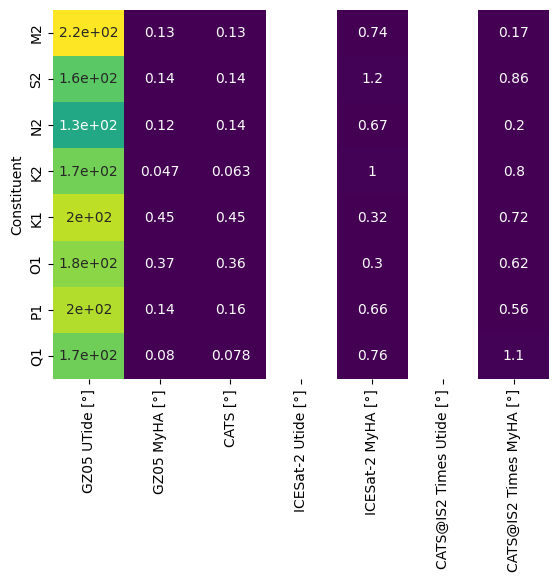

In [27]:
# Summary Plot Phase

# Table of constitutents colored by True - Estimated from my simple HA and python's UTide

df_plotting = pd.DataFrame(
    {
        "Constituent": list(constituents.keys()),
        "GZ05 UTide [°]": true_values[8:],
        "GZ05 MyHA [°]": [
            0.12663,
            0.13840,
            0.11655,
            0.04692,
            0.45270,
            0.36785,
            0.14390,
            0.08005,
        ],  # From UTide on SERAC
        "CATS [°]": [
            0.12530586123466492,
            0.14462734758853912,
            0.13967309892177582,
            0.06251237541437149,
            0.44746169447898865,
            0.35937005281448364,
            0.15769679844379425,
            0.07832222431898117,
        ],
        "ICESat-2 Utide [°]": [np.nan] * 8,
        "ICESat-2 MyHA [°]": IS2_MYHA[8:],
        "CATS@IS2 Times Utide [°]": [np.nan] * 8,
        "CATS@IS2 Times MyHA [°]": CATS_AT_IS2[8:],
    }
)

# Make plot
df_for_plot = df_plotting.set_index(df_plotting.columns[0])
plot = sns.heatmap(df_for_plot, annot=True, cmap="viridis", cbar=False)